In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys
import scipy.io as sio

# 1. Convertimos los datos usando $\Delta_{ID}=1$

In [29]:
dir_path = 'masks/'
# add this path to the system path
sys.path.append(dir_path)

In [34]:
files = os.listdir(dir_path)

['Artana',
 'Beneixama',
 'Beniarda',
 'Bolulla',
 'Carcaixent',
 'Chella',
 'Gatova',
 'Llutxent',
 'Montan',
 'ValldEbo',
 'VallGallinera']

In [43]:
# create a dictionary of the masks
masks = {}

for file in files:
    name = file.split('_')[0]
    array = sio.loadmat(dir_path + file)['masks']
    n_steps = array.shape[-1]
    grid = np.zeros_like(array)
    grid[:, :, 0] = array[:, :, 0].copy()
    for i in range(1, n_steps):
        grid[:,:,i][grid[:,:,i-1]>=1] = 2
        grid[:,:,i][grid[:,:,i-1]==0] = array[:,:,i][grid[:,:,i-1]==0].copy()    
    masks[name] = grid.copy()


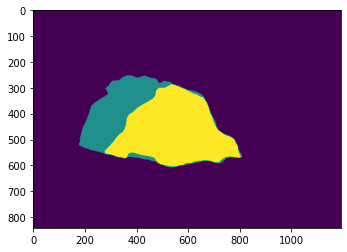

In [48]:
plt.imshow(masks['Artana'][:, :, 3])

# 2. Guardamos los datos en formato binario

In [52]:
import pickle
with open('grid_data_dict/masks.pkl', 'wb') as f:
    pickle.dump(masks, f)

In [53]:
masks = pickle.load(open('grid_data_dict/masks.pkl', 'rb'))

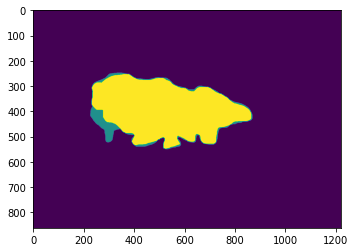

In [56]:
plt.imshow(masks['Beneixama'][:, :, -2])